# Self-Training
**Student Name:** Ashraful Islam Tanzil  
**ID:** 0112230028

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
df = pd.read_csv('../../dataset/SEMI_SUPERVISED_LEARNING/breast_Cancer.csv')

y = df.iloc[:, -1].values


numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numeric_cols].values

for i, col in enumerate(numeric_cols):
    mask = np.isnan(X[:, i])
    if mask.any():
        X[mask, i] = np.nanmean(X[:, i])

print(f'Data shape: {X.shape}')

le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

n_unlabeled = len(y_train) // 2
unlabeled_idx = np.random.choice(len(y_train), n_unlabeled, replace=False)
y_train_partial = y_train.copy()
y_train_partial[unlabeled_idx] = -1

print(f'Labeled: {np.sum(y_train_partial >= 0)}')
print(f'Unlabeled: {np.sum(y_train_partial == -1)}')

Data shape: (569, 32)
Labeled: 228
Unlabeled: 227


C:\Users\Tanzil\AppData\Local\Temp\ipykernel_8016\1967451962.py:12: RuntimeWarning: Mean of empty slice
  X[mask, i] = np.nanmean(X[:, i])
c:\Users\Tanzil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1207: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Tanzil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1212: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Tanzil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1236: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [3]:
base_clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
self_train = SelfTrainingClassifier(estimator=base_clf, threshold=0.75)
self_train.fit(X_train, y_train_partial)

y_pred = self_train.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114



c:\Users\Tanzil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


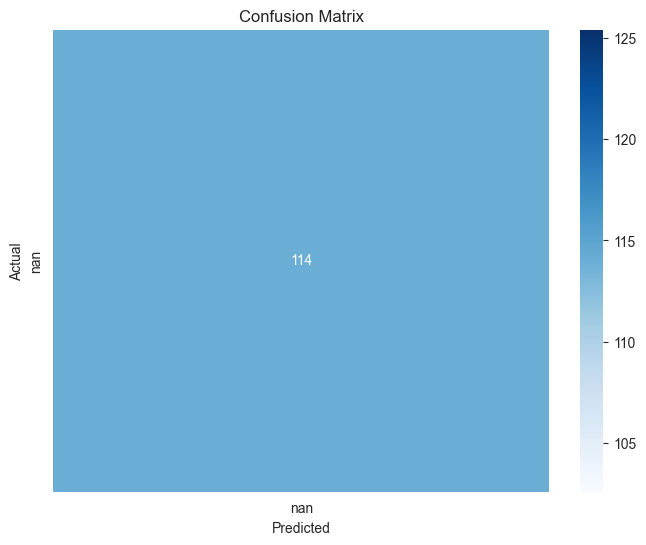

In [4]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

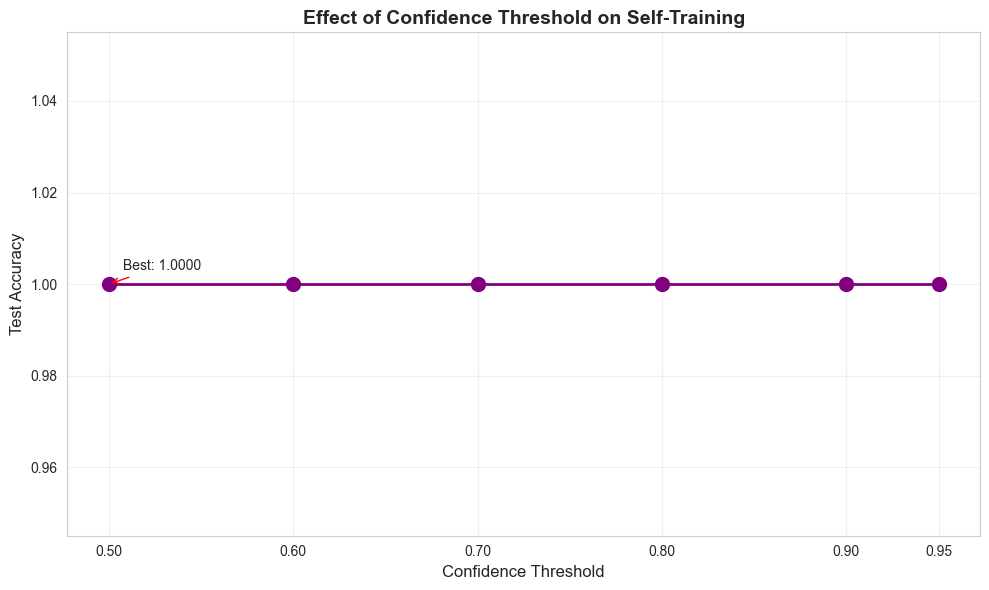

In [5]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
threshold_results = []

for thresh in thresholds:
    st_clf = SelfTrainingClassifier(
        estimator=RandomForestClassifier(n_estimators=100, random_state=42),
        threshold=thresh
    )
    st_clf.fit(X_train, y_train_partial)
    acc = accuracy_score(y_test, st_clf.predict(X_test))
    threshold_results.append({'threshold': thresh, 'accuracy': acc})

thresh_df = pd.DataFrame(threshold_results)

plt.figure(figsize=(10, 6))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], 'o-', linewidth=2, markersize=10, color='purple')
plt.xlabel('Confidence Threshold', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Effect of Confidence Threshold on Self-Training', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(thresholds)

# Annotate best point
best_idx = thresh_df['accuracy'].idxmax()
plt.annotate(f'Best: {thresh_df.loc[best_idx, "accuracy"]:.4f}',
             xy=(thresh_df.loc[best_idx, 'threshold'], thresh_df.loc[best_idx, 'accuracy']),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.savefig('semi_07_threshold_effect.png', dpi=300, bbox_inches='tight')
plt.show()